In [1]:
import os, gc, torch

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars
from models.load import get_trained_model
from utils.coco_eval import get_eval_params_dict
from data.datasets import  OurRadiologsitsDataset, collate_fn
from our_radiologist.load import get_anns
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.coco_utils import get_cocos, get_coco_api_from_dataset
from utils.eval import get_ar_ap
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
from utils.constants import full_iou_thrs, iou_thrs_5to95
from data.load  import seed_worker, get_dataloader_g
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from utils.save import get_data_from_metric_logger
from data.datasets import ReflacxDataset, collate_fn
from utils.detect_utils import MetricLogger
from utils.coco_eval import CocoEvaluator, external_summarize
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

c:\Users\mike8\Desktop\multimodal-abnormalities-detection\models\detectors\rcnn.py:834: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])


In [4]:
from enum import Enum

class TrainedModels(Enum):
    # without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"

    # without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"
    
    ## original one.
    # with_clinical = "val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical"

    # ## smaller lr=1e-4
    # with_clinical_lr4 = "val_ar_0_6977_ap_0_4386_test_ar_0_7352_ap_0_4241_epoch59_WithClincal_05-01-2022 18-58-42_ov_13"

    # ## smaller lr=1e-3
    # with_clinical_lr3 = "val_ar_0_7641_ap_0_4498_test_ar_0_7120_ap_0_4252_epoch81_WithClincal_05-01-2022 16-52-32_ov_12"

    # with_clinical_lr3_200 = "val_ar_0_7222_ap_0_4626_test_ar_0_6727_ap_0_4956_epoch111_WithClincal_05-03-2022 20-39-41_ov_12"

    # with_clinical_final = "val_ar_0_7269_ap_0_4601_test_ar_0_6710_ap_0_4286_epoch100_WithClincal_05-02-2022 19-03-30_with_clinical"


    # it seems the final two model we will be using.
    # without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"

    # without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"

    # with_clinical_lr3_200 = "val_ar_0_7222_ap_0_4626_test_ar_0_6727_ap_0_4956_epoch111_WithClincal_05-03-2022 20-39-41_ov_12"

    # with_clinical_lr3_200_final = "val_ar_0_6650_ap_0_3870_test_ar_0_6604_ap_0_4493_epoch200_WithClincal_05-03-2022 23-04-30_ov_12"


    CXR_Clinical_ap = "val_ar_0_9381_ap_0_6945_test_ar_0_8224_ap_0_6378_epoch20_WithClincal_05-16-2022 18-13-10_CXR+Clinical"
    CXR_Clinical_final = "val_ar_0_9556_ap_0_6776_test_ar_0_7849_ap_0_6534_epoch71_WithClincal_05-16-2022 19-38-03_CXR+Clinical"

    CXR_ap = "val_ar_0_7518_ap_0_5042_test_ar_0_5388_ap_0_3255_epoch22_WithoutClincal_05-16-2022 20-18-25_CXR"
    CXR_final = "val_ar_0_5966_ap_0_4046_test_ar_0_5388_ap_0_3893_epoch54_WithoutClincal_05-16-2022 21-10-18_CXR"

In [22]:
select_model = TrainedModels.CXR_final

model, train_info, _ = get_trained_model(
    select_model,
    DEFAULT_REFLACX_LABEL_COLS,
    device,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)

model.to(device)
model.eval()


Load custom model
Using pretrained backbone. mobilenet_v3
Found optimizer for this model.
Using SGD as optimizer with lr=0.001


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    

========================================For Training [CXR+Clinical]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR+Clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=30, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=[30, 50, 70, 90], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=32, clinical_num_len=9, clinical_conv_channels=32, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4, 

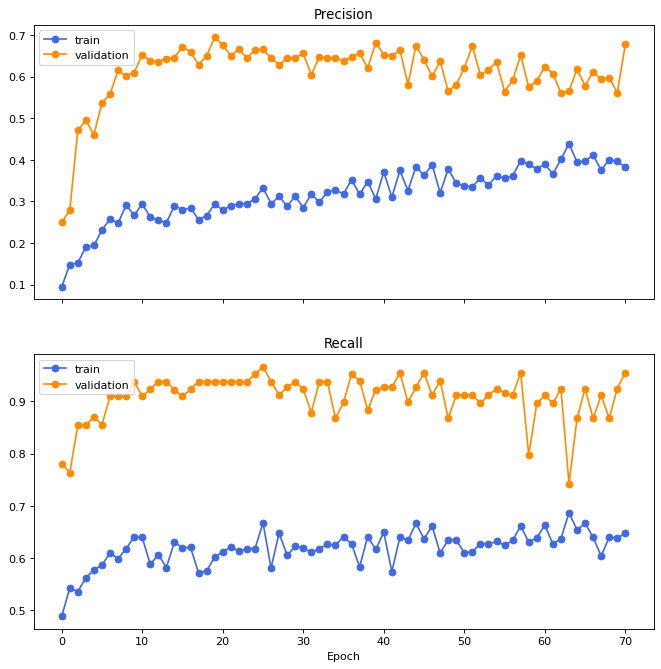

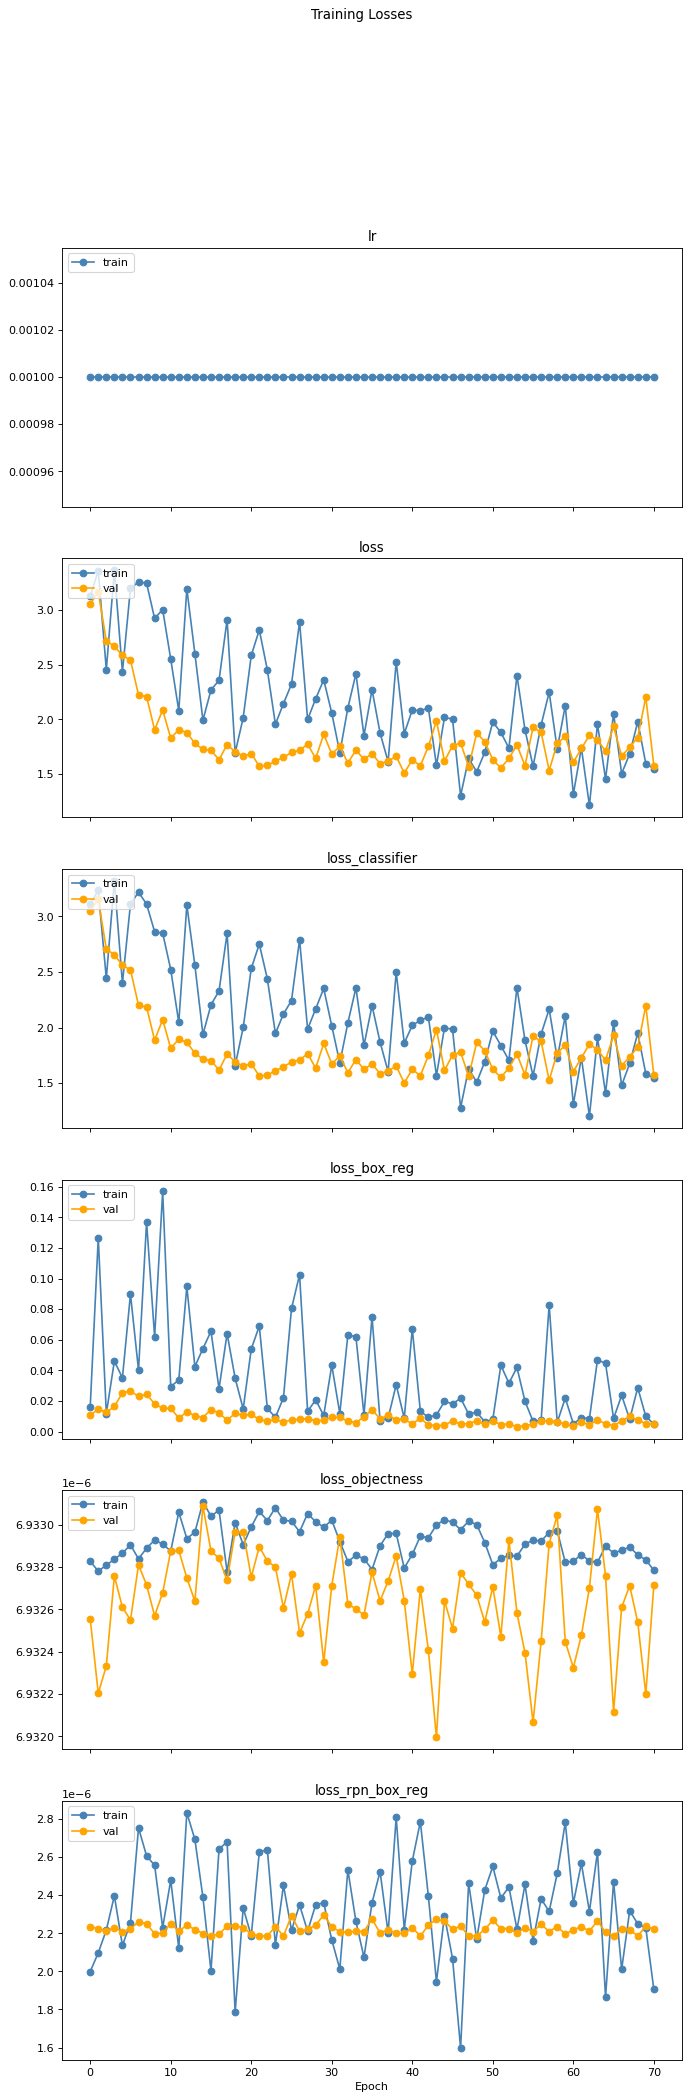

In [6]:
print(train_info)
print_params_setup(model)
plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
plot_losses(train_info.train_data, train_info.val_data)


In [7]:
model_setup = train_info.model_setup
dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": model_setup.use_clinical,
    "dataset_mode": model_setup.dataset_mode,
    "bbox_to_mask": model_setup.use_mask,
    "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
}

In [8]:
get_ar_ap(train_info.test_evaluator)

(0.7848684210526315, 0.6533913512134953)

In [9]:
train_info.model_setup.dataset_mode

'unified'

In [10]:
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
)

train_coco, val_coco, test_coco = get_cocos(
    train_dataloader, val_dataloader, test_dataloader
)

eval_params_dict = get_eval_params_dict(
    detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
)

iou_types = get_iou_types(model, model_setup)


creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


In [11]:
# data = next(iter(test_dataloader))
# data = test_dataloader.dataset.prepare_input_from_data(data, device)
# model.eval()
# model(*data[:-1])

In [23]:
evaluator, logger = xami_evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            score_thres=None,
        )

Evaluation:  [ 0/15]  eta: 0:00:11  loss: 0.0123 (0.0123)  loss_classifier: 0.0123 (0.0123)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0320 (0.0320)  evaluator_time: 0.0022 (0.0022)  time: 0.7758  data: 0.5252  max mem: 549
Evaluation:  [14/15]  eta: 0:00:00  loss: 0.3232 (0.3670)  loss_classifier: 0.2436 (0.2993)  loss_box_reg: 0.0544 (0.0677)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0390 (0.0371)  evaluator_time: 0.0016 (0.0016)  time: 0.6724  data: 0.5586  max mem: 549
Evaluation: Total time: 0:00:10 (0.6725 s / it)
Averaged stats: loss: 0.3232 (0.3670)  loss_classifier: 0.2436 (0.2993)  loss_box_reg: 0.0544 (0.0677)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0390 (0.0371)  evaluator_time: 0.0016 (0.0016)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area=   all |

In [24]:
get_ar_ap(evaluator)[1]

0.12107551201825181

In [25]:
model.roi_heads.score_thresh = 0.3

In [26]:
evaluator_3, logger_3 = xami_evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            score_thres=None,
        )

Evaluation:  [ 0/15]  eta: 0:00:10  loss: 0.2300 (0.2300)  loss_classifier: 0.1812 (0.1812)  loss_box_reg: 0.0488 (0.0488)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0350 (0.0350)  evaluator_time: 0.0002 (0.0002)  time: 0.6974  data: 0.5973  max mem: 549
Evaluation:  [14/15]  eta: 0:00:00  loss: 0.2807 (0.3960)  loss_classifier: 0.2302 (0.3248)  loss_box_reg: 0.0472 (0.0712)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0360 (0.0360)  evaluator_time: 0.0010 (0.0010)  time: 0.6655  data: 0.5640  max mem: 549
Evaluation: Total time: 0:00:09 (0.6656 s / it)
Averaged stats: loss: 0.2807 (0.3960)  loss_classifier: 0.2302 (0.3248)  loss_box_reg: 0.0472 (0.0712)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0360 (0.0360)  evaluator_time: 0.0010 (0.0010)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area=   all |

In [27]:
get_ar_ap(evaluator_3)[1]

0.08235390456338866

In [28]:
model.roi_heads.score_thresh = 0.1
evaluator_1, logger_1 = xami_evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            score_thres=None,
        )

Evaluation:  [ 0/15]  eta: 0:00:09  loss: 0.0030 (0.0030)  loss_classifier: 0.0030 (0.0030)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0350 (0.0350)  evaluator_time: 0.0010 (0.0010)  time: 0.6651  data: 0.5641  max mem: 549
Evaluation:  [14/15]  eta: 0:00:00  loss: 0.2900 (0.3614)  loss_classifier: 0.2716 (0.2937)  loss_box_reg: 0.0600 (0.0677)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0370 (0.0374)  evaluator_time: 0.0010 (0.0012)  time: 0.6619  data: 0.5589  max mem: 549
Evaluation: Total time: 0:00:09 (0.6621 s / it)
Averaged stats: loss: 0.2900 (0.3614)  loss_classifier: 0.2716 (0.2937)  loss_box_reg: 0.0600 (0.0677)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.0370 (0.0374)  evaluator_time: 0.0010 (0.0012)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.50:0.50 | area=   all |

In [29]:
get_ar_ap(evaluator_1)[1]

0.11587749221627161